In [2]:
from IPython.display import Image, display
from keras.preprocessing.image import load_img
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from keras.applications import mobilenet_v2
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

## Abstract
Modele uczenia maszynowego stały się w ostatnich latach dość rozbudowane, co spowodowało ich pewnego rodzaju enigmatyczność, nieinterpretowalność. Często jako użytkownicy korzystamy z ów modeli, architektur jako pewnego rodzaju black-box'y, nie wiedząc co wykonuje się wewnątrz. Jednakże wykorzystywanie rozbudowanych, złożonych algorytmów powoduje, iż pomimo wiedzy dotyczącej funkcjonowania podanego modelu, i tak jako jednostka ludzka nie jesteśmy w stanie stwierdzić poprawnie zachowania modelu, gdyż jest po prostu zbyt złożony dla nietrywialnych zadań.  
Właśnie dlatego z pomocą przychodzą nam metody XAI, pozwalające nam, w szczególności w analizie obrazów, w przystępny sposób zademonstrować "sposób działania" danego modelu i na tej podstawie przedstawić interpretowalny dla jednostki ludzkiej schemat działania.

### Wybrany model
W danej pracy domowej posłużę się modelem ResNet, który charakteryzuję się swoim podejściem poprzez analogię do funkcjonowania neuronów w ludzkiej korze mózgowej. W danym modelu istnieją *przeskokowe połączenia* bądź *skróty* pomiędzy niektórymi warstwami sieci neuronowej, których zadanie zostało oddane dość deskryptywnie przez ich nazwy, mają przenosić input z jednej warstwy do innej, z pominięciem, najczęściej jednej lub dwóch, następujących warstw. Autorzy modelu twierdzą, iż zastosowanie takiego rozwiązania znacznie przyspiesza uczenie się modelów, które są znane z powolności oraz pozwala na uniknięcie problemu vanishing gradient (szczerze nie wiem jaki jest odpowiednik w polskim, zanikający gradient?).

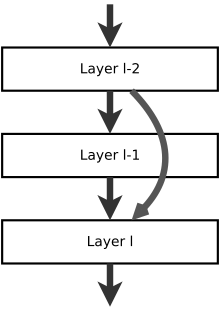

In [2]:
display(load_img("abstract.png"))

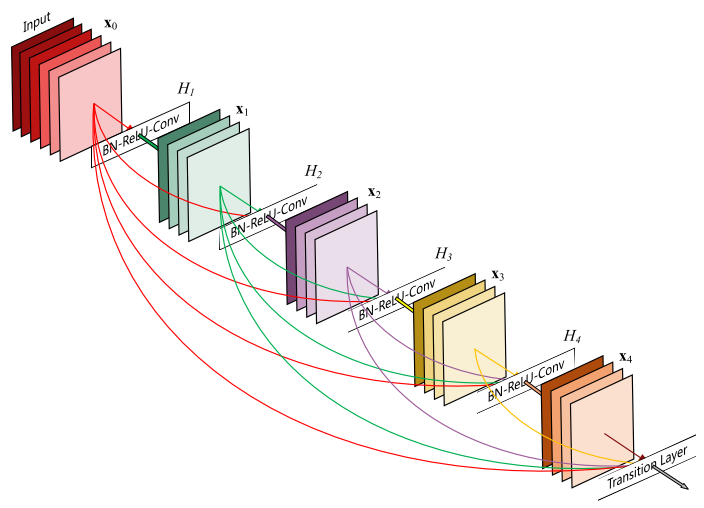

In [3]:
display(load_img("abstract2.png"))

Wgrajmy model z wytrenowanymi już wagami, posłużę się wariantem ResNet50

In [3]:
model = tf.keras.applications.ResNet50(weights="imagenet")

Przygotujmy funkcje do wczytania, obróbki i prezentacji wyników sieci neuronowej.

In [4]:
def image_load_and_process(image):
    image = img_to_array(image)
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    image = preprocess_input(image)
    return image

def label_image(image):
    display(image)
    labels = decode_predictions(model.predict(image_load_and_process(image)))[0]
    for i in labels:
        print("Predicted label:",i[1].capitalize(), "\nProbability:", "%.3f" % (i[2]*100),"%\n") 


Załadujmy pewne zdjęcia, które następnie sklasyfikujemy, zdjęcia dobrałem tak by każde odzwierdziedlało pewien istniejący już
label. Jedno z zdjęć dobrałem specjalnie by "oszukać" nasz model by źle go sklasyfikował.

In [97]:
images_set = []
images_set.append(load_img("Images\\tiger.png"))
images_set.append(load_img("Images\\tracktor.png"))
images_set.append(load_img("Images\\gorilla.png"))
images_set.append(load_img("Images\\parrots.png"))
images_set.append(load_img("Images\\pepe.png"))
images_set.append(load_img("Images\\dog_mug.png"))
images_set.append(load_img("Images\\group_of_people.png"))

Sprawdźym jak sprawdz się model na naszych danych:

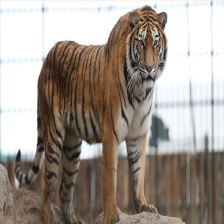

Predicted label: Tiger 
Probability: 86.969 %

Predicted label: Tiger_cat 
Probability: 10.406 %

Predicted label: Lynx 
Probability: 1.321 %

Predicted label: Zebra 
Probability: 0.969 %

Predicted label: Jaguar 
Probability: 0.050 %



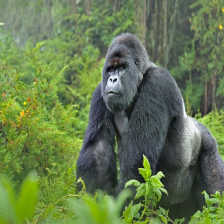

Predicted label: Gorilla 
Probability: 99.892 %

Predicted label: Chimpanzee 
Probability: 0.034 %

Predicted label: Siamang 
Probability: 0.030 %

Predicted label: Gibbon 
Probability: 0.015 %

Predicted label: Macaque 
Probability: 0.012 %



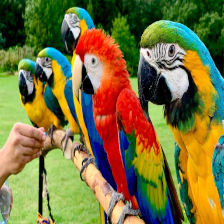

Predicted label: Macaw 
Probability: 99.662 %

Predicted label: Lorikeet 
Probability: 0.158 %

Predicted label: African_grey 
Probability: 0.029 %

Predicted label: Mask 
Probability: 0.009 %

Predicted label: Sulphur-crested_cockatoo 
Probability: 0.008 %



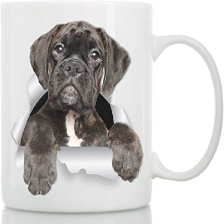

Predicted label: Bull_mastiff 
Probability: 54.953 %

Predicted label: Cup 
Probability: 22.614 %

Predicted label: Coffee_mug 
Probability: 10.843 %

Predicted label: Pitcher 
Probability: 3.798 %

Predicted label: Coffeepot 
Probability: 1.717 %



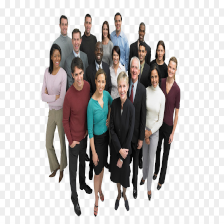

Predicted label: King_penguin 
Probability: 30.485 %

Predicted label: Chain 
Probability: 9.753 %

Predicted label: Parachute 
Probability: 9.486 %

Predicted label: Swimming_trunks 
Probability: 8.570 %

Predicted label: Bikini 
Probability: 5.944 %



In [99]:
label_image(images_set[0])
label_image(images_set[2])
label_image(images_set[3])
label_image(images_set[5])
label_image(images_set[6])

Jak widzimy, pierwsze trzy pierwsze obrazki zostały sklasyfikowane z bardzo dużą precyzją,czwarty był trochę podchwytliwy, niemniej jednak model zwrócił kilka pasujących labeli, podczas gdy ostatni, został całkowicie błędnie przypisany, przyrównując grupę ludzi do pingwina królewskiego. Czyli udało nam się oszukać model, hura!

## GRAD-CAM
Na początku zajmijmy się algorytmem GRAD-CAM, lecz pierw zdefiniujmy potrzebne nam funkcje, któe zostały zaczerpnięte ze następującej strony: https://keras.io/examples/vision/grad_cam/ 

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [8]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [29]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))

Sprawdźmy poprawność pobranych funkcji, jak widzać działają i zwracają porządany efekt.

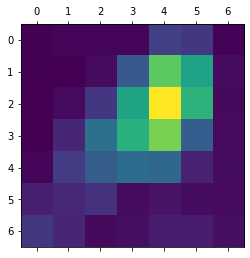

In [10]:
model.layers[-1].activation = None

im = preprocess_input(get_img_array("Images\\tiger.png", size=(224,224)))
heatmap = make_gradcam_heatmap(im, model, "conv5_block3_out",pred_index = 292)

plt.matshow(heatmap)
plt.show()

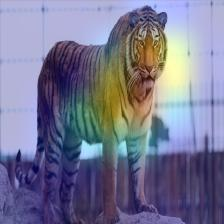

In [11]:
save_and_display_gradcam("Images\\tiger.png", heatmap, alpha=0.4)

Po wczytaniu potrzebnych funkcji, teraz zdefiniujmy kilka naszych dla ułatwienia wizualizacji "myślenia" maszyny podczas wyboru danego labela dla danego obrazka.

In [92]:
#Funkcja zwracająca heatmapy dla trzech najbardziej znaczących labeli w predykcji
def show_top3_heatmaps(image_path,model):
    image = preprocess_input(get_img_array(image_path, size=(224,224)))
    predictions = model.predict(image)
    top = mobilenet_v2.decode_predictions(predictions)
    top = top[0][:3]
    top_indices = np.argsort(predictions)[0, ::-1][:3]
    model.layers[-1].activation = None
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    for ax,i,j in [(axs[0],0,top[0]),(axs[1],1,top[1]),(axs[2],2,top[2])]:
        heatmap = make_gradcam_heatmap(image, model, "conv5_block3_out",pred_index = top_indices[i])
        save_and_display_gradcam(image_path, heatmap, alpha=0.4)
        ax.imshow(load_img("cam.jpg"))
        ax.set_title("With label: " + j[1])
        ax.grid(False)
        ax.axis('off')
plt.show()

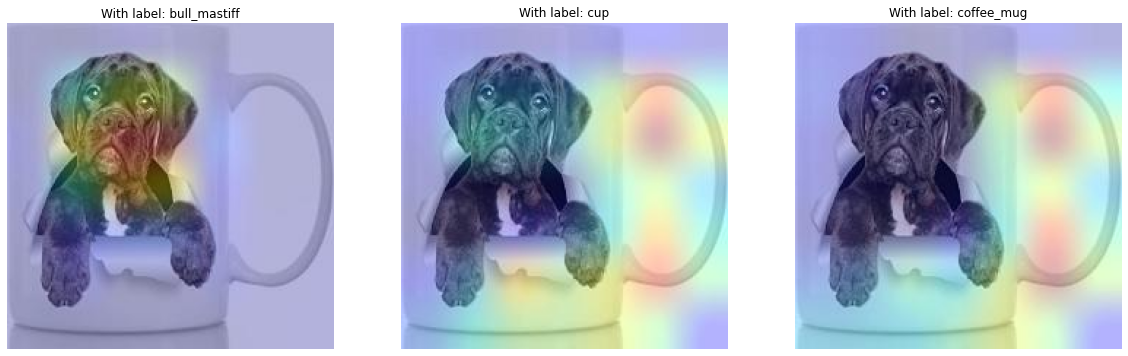

In [93]:
show_top3_heatmaps("Images\\dog_mug.png",model)

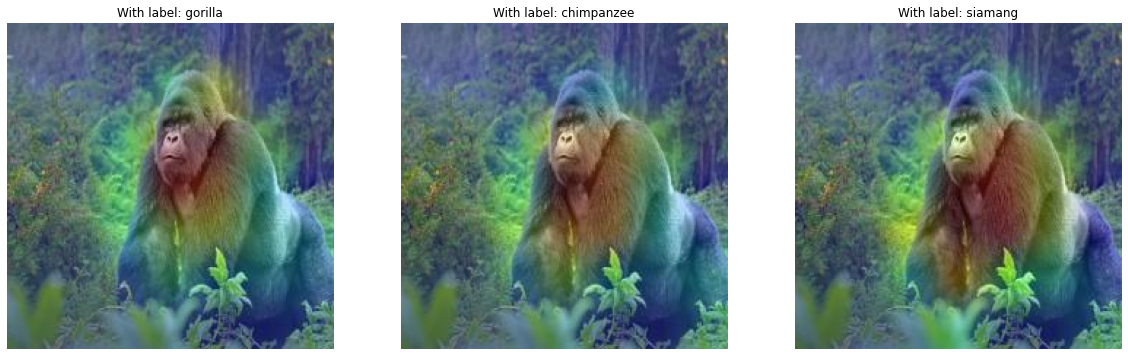

In [94]:
show_top3_heatmaps("Images\\gorilla.png",model)

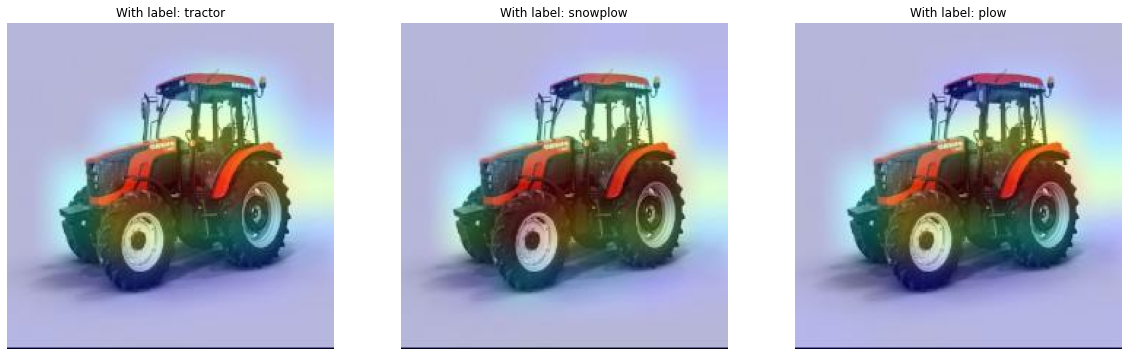

In [101]:
show_top3_heatmaps("Images\\tracktor.png",model)

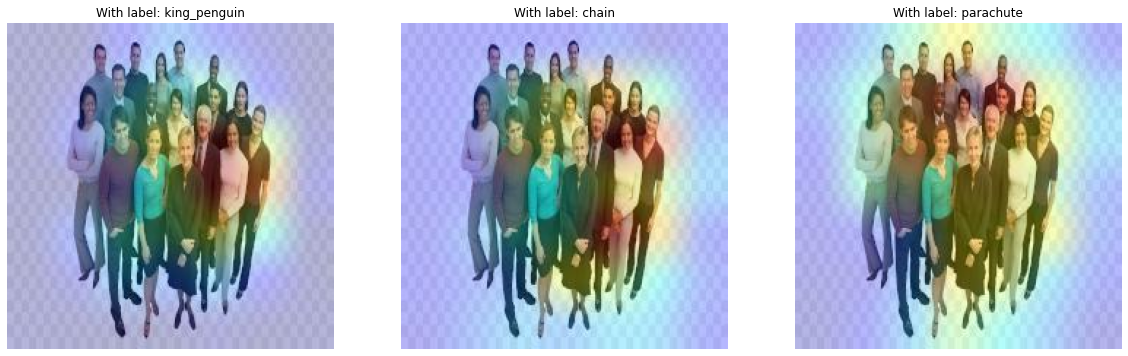

In [98]:
#Ten przypadek będzie najciekawszy, ze względu na bardzo nietrafione labele
show_top3_heatmaps("Images\\group_of_people.png",model)

W przypadku algorytmu GRAD-CAM, widzimy, iż nasz model nie miał praktycznie żadnych problemów z klasyfikacją goryla oraz traktora. Model w pełni skupił się na głównym rejonie obrazka, praktycznie dla wszystkich labeli w równym stopniu, ze względu na ich bliskość oraz przez znaczną przewagę pierwszego label'a w ich podziale.  
Ciekawsza sytuacja tyczy się obrazka przedstawiającego kubek ze obrazem mastiff'a nań. Podłożona "podstępna" grafika została jednak zklasyfikowana w poprawny sposób, pomimo występowania kilku poprawnych labeli. Nie trudno zauważyć, iż model w swoich predykcjach skupiał się na twarzy psa dla pierwszego labela, oraz na uchwycie kubka dla labelu drugiego oraz trzeciego.  
Jednakże najciekawsza sytuacja ma miejsce dla ostatniego obrazka, z którym model po prostu sobie nie poradził. Ciężko mi powiedzieć dlaczego model skupił się na garstce ludzi w prawym dolnym rogu i uznał, iż reprezentują pingwina królewskiego lub łańcuchy i szczerze ciężko jest mi to stwierdzić. Dla trzeciego labela garstka ludzi ulokowanych na krańcach została uznana jako spadochron.

## LIME
Wedle polecenia przejdźmy teraz do drugiego algorymtu XAI, mianowicie Lime.  
Wszystkie potrzebne funkcje by korzystać z algorytmu LIME pobrałęm z następującego repozytorium : https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb  
oraz strony : https://www.kaggle.com/yohanb/explaining-keras-model-with-lime

In [104]:
import os,sys
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

Dokonajmy definicji ponownie funkcji, które pomogą nam w wizualizacji procesów myślowych modelu.

In [199]:
def make_explenation(image_path,model):
    explainer = lime_image.LimeImageExplainer(random_state = 42)
    explanation = explainer.explain_instance(img_to_array(load_img(image_path, target_size=(224, 224))).astype('double'),model.predict, top_labels=3, hide_color=0, num_samples=1000)
    return explanation
    
def top_three_labels(image_path,model):
    explanation = make_explenation(image_path,model)
    fig, ax = plt.subplots(1, 4, sharex='col', sharey='row')
    fig.set_figwidth(20)
    fig.set_figheight(16)
    ax[0].imshow(load_img(image_path))
    ax[0].set_title("Original image")
    image = preprocess_input(get_img_array(image_path, size=(224,224)))
    predictions = model.predict(image)
    top = mobilenet_v2.decode_predictions(predictions)
    top = top[0][:3]
    for i,j in [(0,top[0]),(1,top[1]),(2,top[2])]:
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=True, num_features=5, hide_rest=True)
        ax[i+1].imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))
        ax[i+1].set_title("With label: " + j[1])

In [184]:
def top_three_labels_heatmap(image_path,model):
    explanation = make_explenation(image_path)
    image = preprocess_input(get_img_array(image_path, size=(224,224)))
    predictions = model.predict(image)
    top = mobilenet_v2.decode_predictions(predictions)
    top = top[0][:3]
    ind =  explanation.top_labels[:3]
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    for ax,i,j in [(axs[0],ind[0],top[0]),(axs[1],ind[1],top[1]),(axs[2],ind[2],top[2])]:
        dict_heatmap = dict(explanation.local_exp[i])
        heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
        ax.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
        ax.set_title("With label: " + j[1])
        ax.axis('off')
    cmap = mpl.cm.cool
    norm = mpl.colors.Normalize(vmin=-heatmap.max(), vmax=heatmap.max())
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),ax=[axs[0],axs[1],axs[2]])

Skoro przygotowaliśmy już potrzebne funkcje, przejdźmy teraz do próby wyjaśnienia modelu przy użyciu Lime dla tych samych grafik.

  0%|          | 0/1000 [00:00<?, ?it/s]

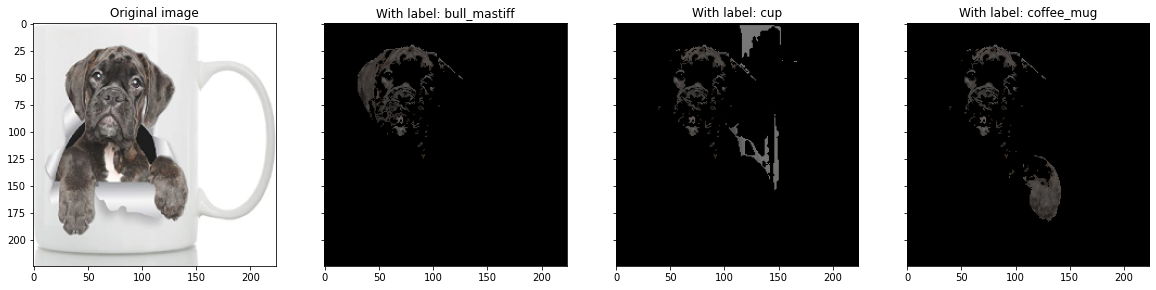

In [200]:
top_three_labels("Images\\dog_mug.png",model)

Przy obrazie kubka z psem, widzimy ponownie podobne wnioski jak w algorytmie GRAD-CAM, model skupiał się w głównej mierze na głowie mastiff'a przy pierwszym labelu, przy drugim objął też swoim zasięgiem kawałek kubka.

  0%|          | 0/1000 [00:00<?, ?it/s]

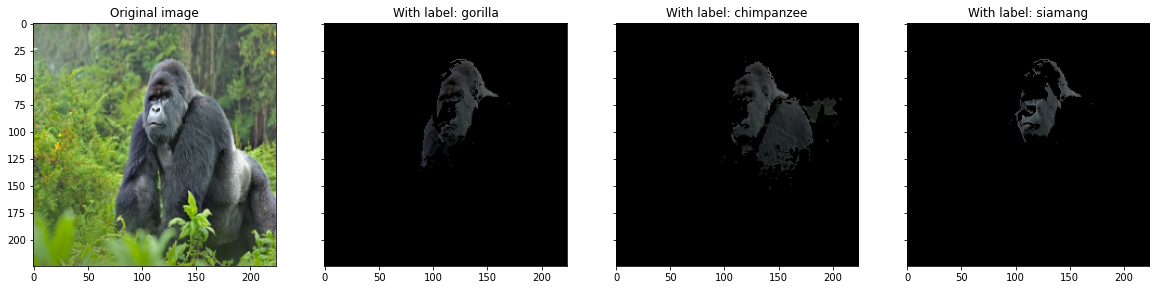

In [188]:
top_three_labels("Images\\gorilla.png",model)

Przypadek goryla jest bardziej klarowny w algorytmie Lime, niźli dla poprzedniego. Pomimo bliskości "gorących" obszarów, analiza przy użyciu Lime pokazała bardziej klarownie części ciała, które w większym stopniu klasyfikowała naczelne, np. goryl był bardziej rozpoznawalny dzięki zarysowi czaski. Pozostałe błędne labele jak widać zostały wybrane przy użyciu nieco innych części ciała.

  0%|          | 0/1000 [00:00<?, ?it/s]

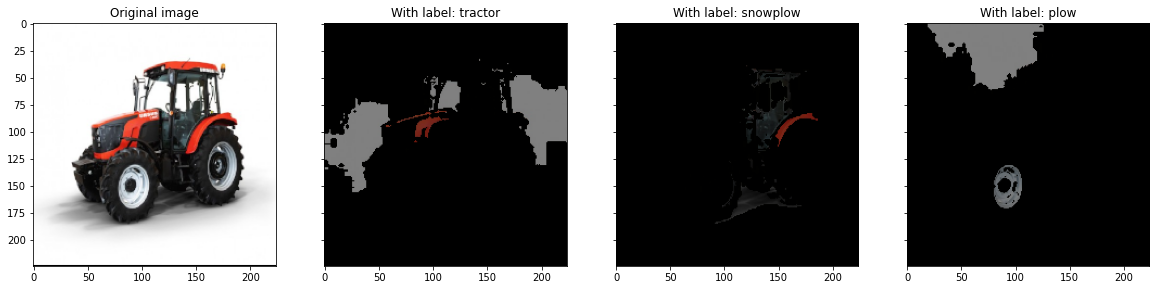

In [190]:
top_three_labels("Images\\tracktor.png",model)

W przypadku traktora również widać klarowniej pod jakim względem został przypisany label w przypadku algorymtu Lime. Widać znacznie uwydatnione części przy klasyfikacji, lecz co także zaskakujące, jednokolorowe tło również odegrało pewną rolę, więc może traktory i pługi były ustawiane w pewien specyficzny sposób.

  0%|          | 0/1000 [00:00<?, ?it/s]

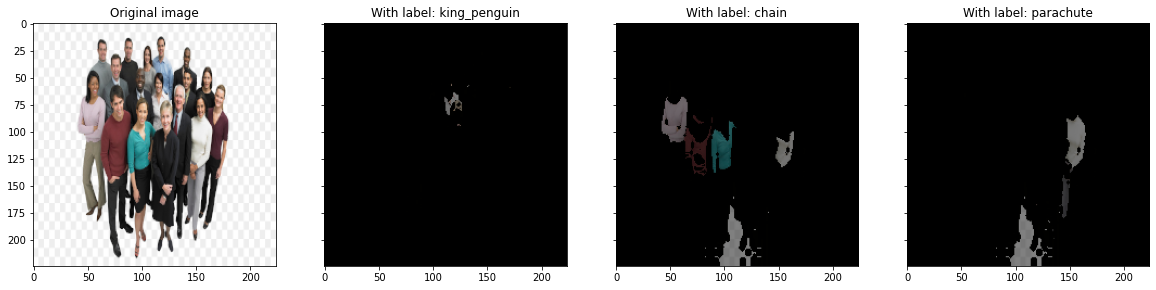

In [191]:
top_three_labels("Images\\group_of_people.png",model)

Przechodząc do perełki naszej analizy, czyli najbardziej przeinaczeonej klasyfikacji. Ciężko cokolwiek powiedzieć na temat schematu doboru labeli przez algorytm. Chociaż zwraca uwagę to, iż w porównaniu z GRAD-CAM, zaznaczone rejony wydają się nieco inne.

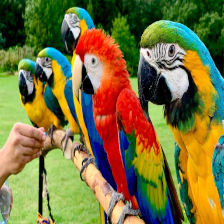

Predicted label: Macaw 
Probability: 99.662 %

Predicted label: Lorikeet 
Probability: 0.158 %

Predicted label: African_grey 
Probability: 0.029 %

Predicted label: Mask 
Probability: 0.009 %

Predicted label: Sulphur-crested_cockatoo 
Probability: 0.008 %



In [202]:
#orygianlny obraz
label_image(images_set[3])

  0%|          | 0/1000 [00:00<?, ?it/s]

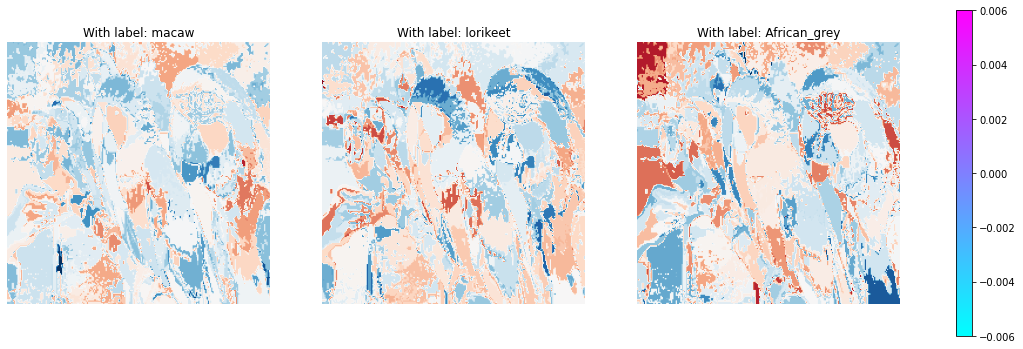

In [201]:
top_three_labels_heatmap("Images\\parrots.png",model)

Jako dodatek postanowiłem dodać mapę obrazu w postaci mapy ciepła dla jeszcze innej grafiki, przedstawionej powyżej.  
Cieplejsze kolory sugerują nam większe znaczenie w doborze danego labela. Ponieważ podana grafika została sklasyfikownana z 99% pewnością toteż nie zobaczymy między heatmapami dużo różnicy, niemniej jednak w oczy rzuca się duży udział tła dla label'a *African_grey* co świadczyć może, iż model wyuczył się rozpoznawać ów ptaki właśnie za pomocą tła, środowiska w jakim występują, a nie cech ich samych.

## Wnioski
Ostatecznie obydwa algorytmy wykazały się podobnym oznaczeniem skupienia najważniejszych cech omawianego obrazu.  
Algorytm LIME wykazał się znacznie dłuższym czasem kompilacji niż jego odpowiednik w tworzeniu map ciepła pikseli.  
W przypadku użycia wyjaśniania maszynowego przy pomocy LIME, można zobaczyć gdzieniegdzie bardziej precyzyjnie dokładność pikseli jaką posługiwał się algorytm, tyczy się to głównie klasyfikacji gdzie GRAD-CAM zwracał mapy ciepła o bardzo skupionym obszarze.  
Jeżeli chodzi o użyty model Res50, to oczywiście nie dysponuję dokładnymi porównaniami czasowymi, jednakże już z doświadczenia z pracą z sieciami neuronowymi mogę stwierdzić, iż w przypadku klasyfikacji danych obrazów, model dokonał jej znacznie szybciej niż zazwyczaj zachodzi tak dla innych sieci.